In [1]:
import pandas as pd
from datetime import datetime
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import f_classif, VarianceThreshold, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.preprocessing import StandardScaler

/home/yjarkko/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/yjarkko/.local/lib/python3.8/site-packages/pandas/core/arrays/masked.py:64: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


### General variables

In [2]:
data_folder = '../../../Data/' #add your own folder name where the csv files are located
print_text_result = False
raw_data_names = ['pit1_data-2022', 'pit2_data-2022', 'pit3_data-2022', 'pit4_data-2022',
                  'pit1_data-2023', 'pit2_data-2023', 'pit3_data-2023', 'pit4_data-2023']
clean_data_names = ['VII_PIT1_2022', 'VII_PIT2_2022', 'VII_PIT3_2022', 'VII_PIT4_2022']

### Helper functions

In [3]:
def remove_pit_suffix(name: str) -> str:
    """
    Remove suffix '_pit<number>' from header
    """
    re_match = re.search(r'_pit\d+$', name)
    if re_match:
        name = name[:re_match.start()]

    return name

def get_mixed_year_dates(df: pd.DataFrame, file_name: str, findings_dict: dict) -> int:
    header = f'{file_name} year not matching'
    start_date_2022 = datetime(2022, 1,1, 0, 0, 0)
    start_date_2023 = datetime(2023, 1,1, 0, 0, 0)
    start_date_2024 = datetime(2024, 1,1, 0, 0, 0)

    if '2022' in file_name:
        findings_dict[header] = (df.loc[(df['TIMESTAMP'] >= start_date_2023) | (df['TIMESTAMP'] < start_date_2022)].index.values + 2)
    else:
        findings_dict[header] = (df.loc[(df['TIMESTAMP'] >= start_date_2024) | (df['TIMESTAMP'] < start_date_2023)].index.values + 2 )

    return len(findings_dict[header])


def get_duplicate_dates(df: pd.DataFrame, file_name: str, findings_dict: dict) -> pd.DataFrame:
    header = f'{file_name} duplicate date'
    findings_dict[header] = (df[df['TIMESTAMP'].duplicated() == True].index.values + 2)

    return len(findings_dict[header])

def get_missing_values(df: pd.DataFrame, file_name: str, findings_dict: dict) -> pd.DataFrame:
    header = f'{file_name} missing values'
    findings_dict[header] = df[df.isnull().any(axis=1)].index.values + 2
    header2 = f'{file_name} missing values col name'
    findings_dict[header2] = df.columns[df.isnull().any()].tolist()

    return len(findings_dict[header])

def get_findings(df: pd.DataFrame, file_name: str, findings_dict: dict) -> dict:
    diff_dict = dict()
    diff_dict['Date_no_match'] = get_mixed_year_dates(df, file_name, findings_dict)
    diff_dict['Duplicates'] = get_duplicate_dates(df, file_name, findings_dict)
    diff_dict['NaNs'] = get_missing_values(df, file_name, findings_dict)

    return diff_dict

def load_data(file_names: list[str], data_folder: str, findings_dict: dict) -> dict:
    dfs = dict()
    
    report_df = pd.DataFrame()

    for file_name in file_names:
        df = pd.read_csv(data_folder+file_name+'.csv', parse_dates=['TIMESTAMP'])
        df.rename(mapper=remove_pit_suffix, axis='columns', inplace=True)

        stats = get_findings(df, file_name, findings_dict)
        report_df = pd.concat([report_df, pd.DataFrame(stats, index=[file_name])])
        dfs[file_name] = df

    report_df = report_df.assign(Total = lambda x: (x.sum(axis=1)))
    report_df['row_cnt'] = [len(df) for df in dfs.values()]
    print(report_df)

    return dfs

### Load data and get findings

In [4]:
findings_dict = dict()
raw_data = load_data(raw_data_names, data_folder, findings_dict)
clean_data = load_data(clean_data_names, data_folder, findings_dict)

/tmp/ipykernel_86178/3030246735.py:2: DtypeWarning: Columns (34,37) have mixed types.Specify dtype option on import or set low_memory=False.
  raw_data = load_data(raw_data_names, data_folder, findings_dict)
/tmp/ipykernel_86178/3030246735.py:2: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  raw_data = load_data(raw_data_names, data_folder, findings_dict)
/tmp/ipykernel_86178/3030246735.py:2: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.
  raw_data = load_data(raw_data_names, data_folder, findings_dict)
/tmp/ipykernel_86178/3030246735.py:2: DtypeWarning: Columns (7,8,9,34,37) have mixed types.Specify dtype option on import or set low_memory=False.
  raw_data = load_data(raw_data_names, data_folder, findings_dict)
/tmp/ipykernel_86178/3030246735.py:2: DtypeWarning: Columns (19,20,21,30,31,34,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  raw_dat

                Date_no_match  Duplicates  NaNs  Total  row_cnt
pit1_data-2022              1          12   267    280    75649
pit2_data-2022              1          24  4348   4373    75949
pit3_data-2022              1          12   167    180    27096
pit4_data-2022              1          12   125    138    27264
pit1_data-2023            287          15   279    581   104918
pit2_data-2023           3250       25839  7215  36304   133640
pit3_data-2023           1154          88   279   1521   106361
pit4_data-2023            290         196  1143   1629   105594


/tmp/ipykernel_86178/3030246735.py:3: DtypeWarning: Columns (37,38,47) have mixed types.Specify dtype option on import or set low_memory=False.
  clean_data = load_data(clean_data_names, data_folder, findings_dict)
/tmp/ipykernel_86178/3030246735.py:3: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  clean_data = load_data(clean_data_names, data_folder, findings_dict)


               Date_no_match  Duplicates   NaNs  Total  row_cnt
VII_PIT1_2022              1         192  76117  76310    76117
VII_PIT2_2022              1          24  72388  72413    75949
VII_PIT3_2022              1          12  19600  19613    27096
VII_PIT4_2022              1          12  25225  25238    25225


/tmp/ipykernel_86178/3030246735.py:3: DtypeWarning: Columns (38) have mixed types.Specify dtype option on import or set low_memory=False.
  clean_data = load_data(clean_data_names, data_folder, findings_dict)


### Save findings as a csv

Each column values are row index in the original csv

In [5]:
findigs_df = pd.DataFrame.from_dict(dict([ (k,pd.Series(v)) for k,v in findings_dict.items() ]))
# findigs_df.to_csv('Data_date_missmatch_duplicate_rows_and_null_values.csv')

### Check where redox values differ in raw and cleaned data and save as csv

Csv contains timestamp and redox values from both raw and cleaned data

In [6]:
# looping through 2022 data
for (raw_name, raw_df), (clean_name, clean_df) in zip(raw_data.items(), clean_data.items()):
    print('Comparing', raw_name, ' vs ', clean_name)
    
    cols = ['TIMESTAMP', 'Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']
    raw_compare = raw_df[cols]
    clean_compare = clean_df[cols]

    # merge Dataframes by matching TIMESTAMP
    merged_df = raw_compare.merge(clean_compare, how='inner', on=['TIMESTAMP'], suffixes=('_raw', '_clean'))

    matching_values = merged_df.apply(lambda x: True if (math.isnan(x['Redox_Avg(1)_clean']) or math.isclose(x['Redox_Avg(1)_raw'], x['Redox_Avg(1)_clean'], rel_tol=1e-3)) and
                                                        (math.isnan(x['Redox_Avg(2)_clean']) or math.isclose(x['Redox_Avg(2)_raw'], x['Redox_Avg(2)_clean'], rel_tol=1e-3)) and
                                                        (math.isnan(x['Redox_Avg(3)_clean']) or math.isclose(x['Redox_Avg(3)_raw'], x['Redox_Avg(3)_clean'], rel_tol=1e-3)) and
                                                        (math.isnan(x['Redox_Avg(4)_clean']) or math.isclose(x['Redox_Avg(4)_raw'], x['Redox_Avg(4)_clean'], rel_tol=1e-3)) and
                                                        (math.isnan(x['Redox_Avg(5)_clean']) or math.isclose(x['Redox_Avg(5)_raw'], x['Redox_Avg(5)_clean'], rel_tol=1e-3)) else False, axis=1)
    
    # Uncomment to check for larger gaps between the raw and clean values
    # matching_values = merged_df.apply(lambda x: True if (math.isnan(x['Redox_Avg(1)_clean']) or abs(x['Redox_Avg(1)_raw'] - x['Redox_Avg(1)_clean']) <= 10) and
    #                                                     (math.isnan(x['Redox_Avg(2)_clean']) or abs(x['Redox_Avg(2)_raw'] - x['Redox_Avg(2)_clean']) <= 10) and
    #                                                     (math.isnan(x['Redox_Avg(3)_clean']) or abs(x['Redox_Avg(3)_raw'] - x['Redox_Avg(3)_clean']) <= 10) and
    #                                                     (math.isnan(x['Redox_Avg(4)_clean']) or abs(x['Redox_Avg(4)_raw'] - x['Redox_Avg(4)_clean']) <= 10) and
    #                                                     (math.isnan(x['Redox_Avg(5)_clean']) or abs(x['Redox_Avg(5)_raw'] - x['Redox_Avg(5)_clean']) <= 10) else False, axis=1)
    
    if len(matching_values[matching_values == False]) > 0:
        print(f'\tFound {len(merged_df[matching_values == False])} missmatch with redox values')
        # merged_df[matching_values == False].to_csv(f'Redox_value_not_same_{raw_name}_vs_{clean_name}')
    else:
        print('\tNO MISSMATCH')

Comparing pit1_data-2022  vs  VII_PIT1_2022
	NO MISSMATCH
Comparing pit2_data-2022  vs  VII_PIT2_2022
	NO MISSMATCH
Comparing pit3_data-2022  vs  VII_PIT3_2022
	NO MISSMATCH
Comparing pit4_data-2022  vs  VII_PIT4_2022
	NO MISSMATCH


### See if raw data has missing values on timestamps where clean data has redox error flag

In [7]:
# looping through 2022 data
for (raw_name, raw_df), (clean_name, clean_df) in zip(raw_data.items(), clean_data.items()):
    print('Comparing', raw_name, ' vs ', clean_name)

    error_flags_timestamp = clean_df[clean_df['Redox_error_flag'] == True]['TIMESTAMP'].to_numpy()
    raw_data_points_with_error_flag = raw_df.loc[raw_df['TIMESTAMP'].isin(error_flags_timestamp) == True]
    raw_data_missing_values = raw_data_points_with_error_flag[raw_data_points_with_error_flag.isnull().any(axis=1)]

    if len(raw_data_missing_values) > 0:
        cols_with_missing_data = raw_data_missing_values.columns[raw_data_missing_values.isnull().any()].tolist()
        cols = ' ,'.join(cols_with_missing_data)
        print(f'\tColumns with missing values:\n\t\t{cols}')
        print(f'\tTotal rows {len(raw_data_missing_values)}')
        rows_index = ' ,'.join(map(str, raw_data_missing_values.index.values+2))
        print(f'\tRow index {rows_index}')
        print('\tRaw data:')
        vals = raw_data_missing_values[['Redox_Avg(1)', *cols_with_missing_data]]
        print(f'{vals}')
        print('\tClean data:')
        vals = clean_df[['Redox_Avg(1)', *cols_with_missing_data]].iloc[raw_data_missing_values.index.values]
        print(f'{vals}')
    else:
        print('\tNO MISSING VALUES FOR REDOX ERROR')

    

Comparing pit1_data-2022  vs  VII_PIT1_2022
	NO MISSING VALUES FOR REDOX ERROR
Comparing pit2_data-2022  vs  VII_PIT2_2022
	Columns with missing values:
		Redox_Avg(2) ,Redox_Avg(3) ,Redox_Avg(4) ,Redox_Avg(5)
	Total rows 2
	Row index 60556 ,60557
	Raw data:
       Redox_Avg(1)  Redox_Avg(2)  Redox_Avg(3)  Redox_Avg(4)  Redox_Avg(5)
60554        223.89           NaN           NaN           NaN           NaN
60555       1023.00           NaN           NaN           NaN           NaN
	Clean data:
       Redox_Avg(1)  Redox_Avg(2)  Redox_Avg(3)  Redox_Avg(4)  Redox_Avg(5)
60554           NaN           NaN           NaN           NaN           NaN
60555           NaN           NaN           NaN           NaN           NaN
Comparing pit3_data-2022  vs  VII_PIT3_2022
	Columns with missing values:
		shfp_wrnng_flg
	Total rows 166
	Row index 1581 ,1582 ,1583 ,1584 ,1585 ,1586 ,1587 ,1588 ,1589 ,1590 ,1591 ,1592 ,1593 ,1594 ,1595 ,1596 ,1597 ,1598 ,1599 ,1600 ,1601 ,1602 ,1603 ,1604 ,1605 ,1606

### Evaluate on the null values on redox_error_flag

Pit2 there are only 2 rows which are to be removed from the training data so no major impact on that.

Pit3 missing values on redox_error_flag = true are from column "shfp_wrnng_flg". These have no impact on the removed values in training data since that column will be removed anyways. This column has no impact on redox_avg based on experts opinions.

### Correlation of redox_avg and other features

In [8]:
def get_corr_metrics(s: pd.Series, val: float) -> pd.Series:
    for i, x in enumerate(s.values):
        if x < val and x > -val:
            s[i] = 0
    return s

def get_df_corr(df: pd.DataFrame, only_redox: bool = False) -> pd.DataFrame:
    # Select numerical parameters
    corr_df = df.select_dtypes(exclude=['bool']).corr()

    # Select Redox_Avg as Y axis and other than Redox_Avg as X axis
    if only_redox:
        corr_df = corr_df.loc[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']].iloc[:,6:]
    return corr_df

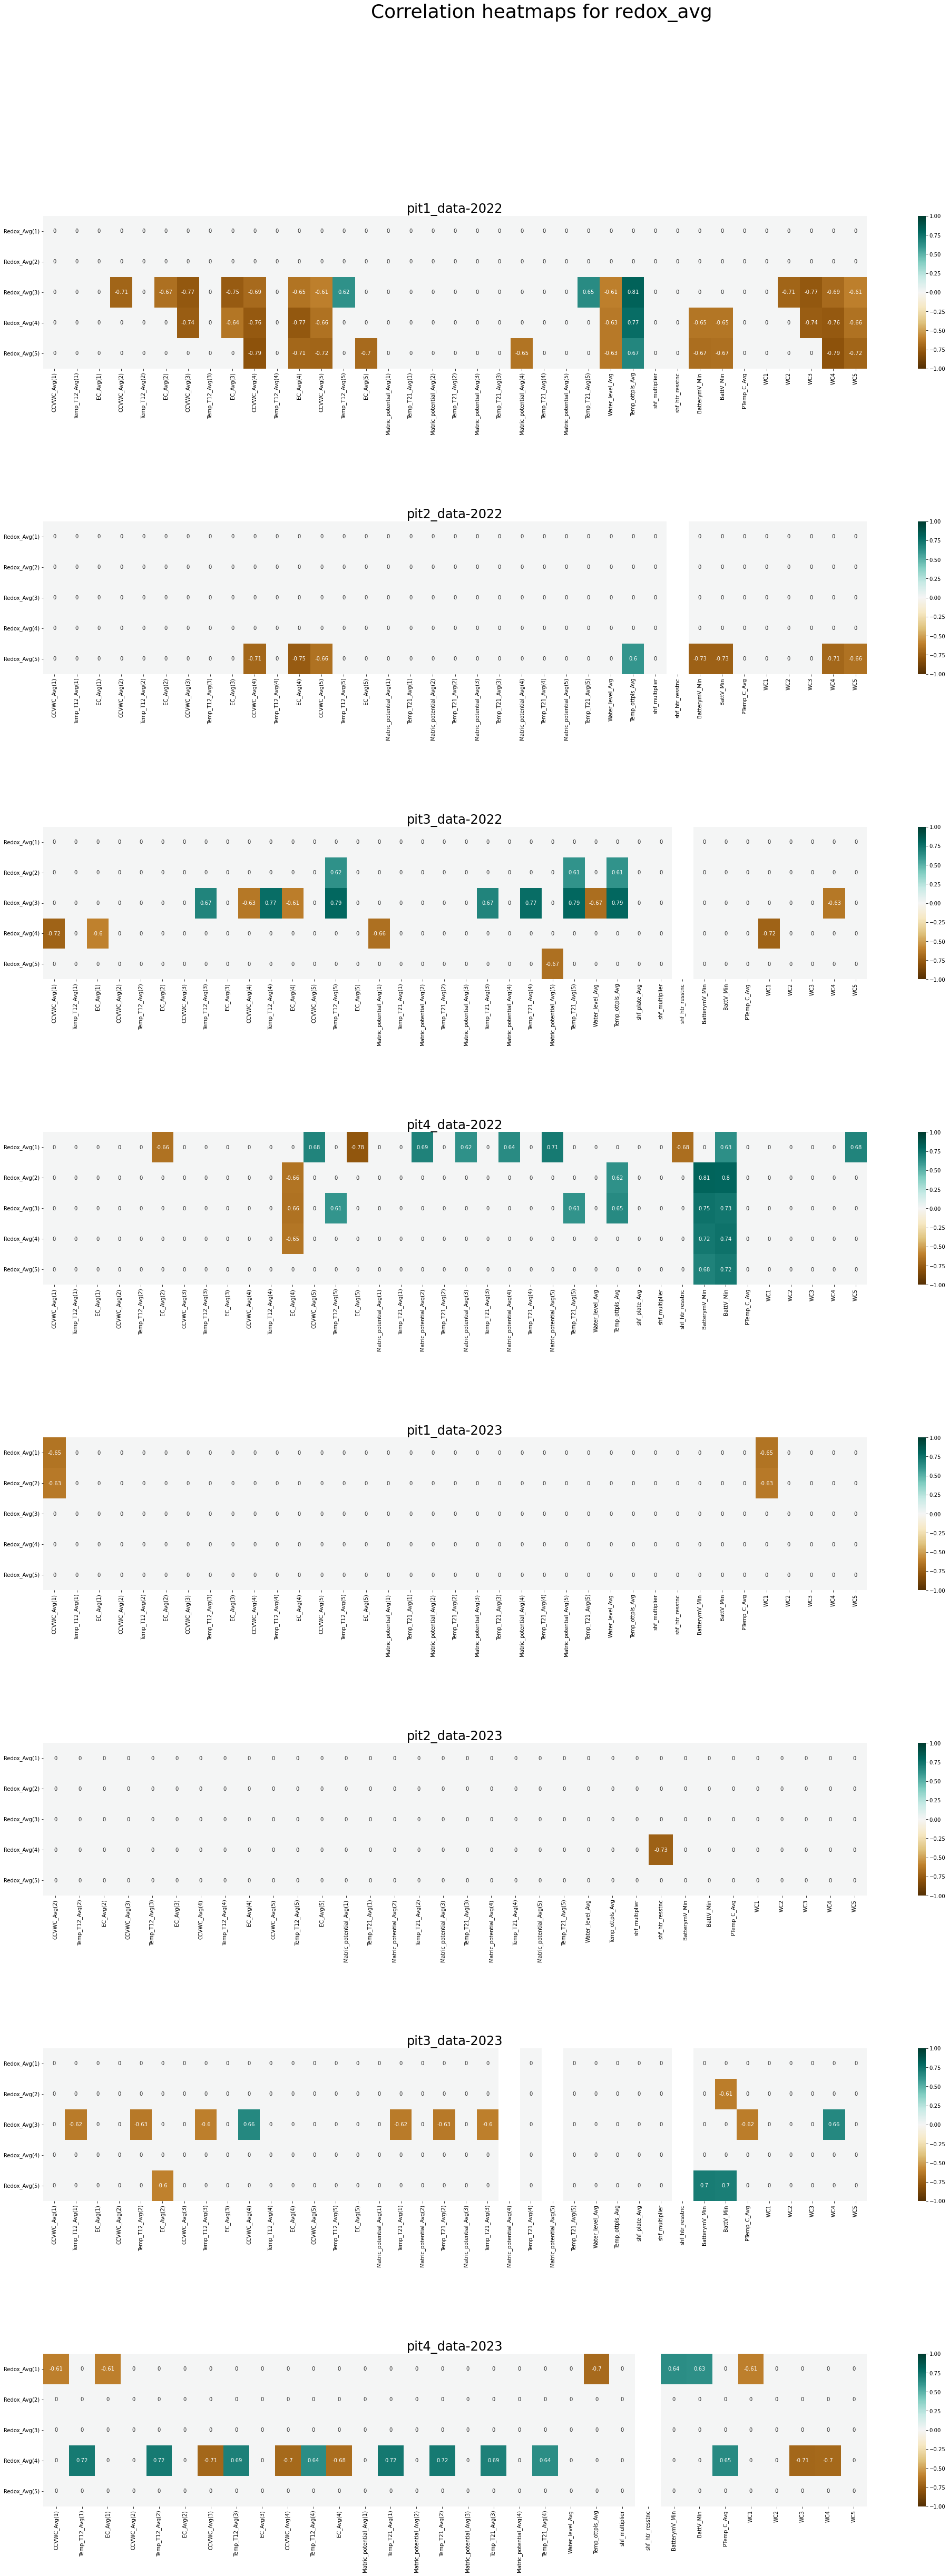

In [9]:
ncols = 1
nrows = len(raw_data.keys())

plt.figure(figsize=(35,nrows*10))
plt.subplots_adjust(hspace=1.0)
plt.suptitle("Correlation heatmaps for redox_avg", fontsize=36, y=0.95)


for n, (d_name, df) in enumerate(raw_data.items()):
    ax = plt.subplot(nrows, ncols, n + 1)

    corr_df = get_df_corr(df, True)
    corr_df = corr_df.apply(lambda x: get_corr_metrics(x, 0.6))

    sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

    ax.set_title(d_name, fontsize = 24)

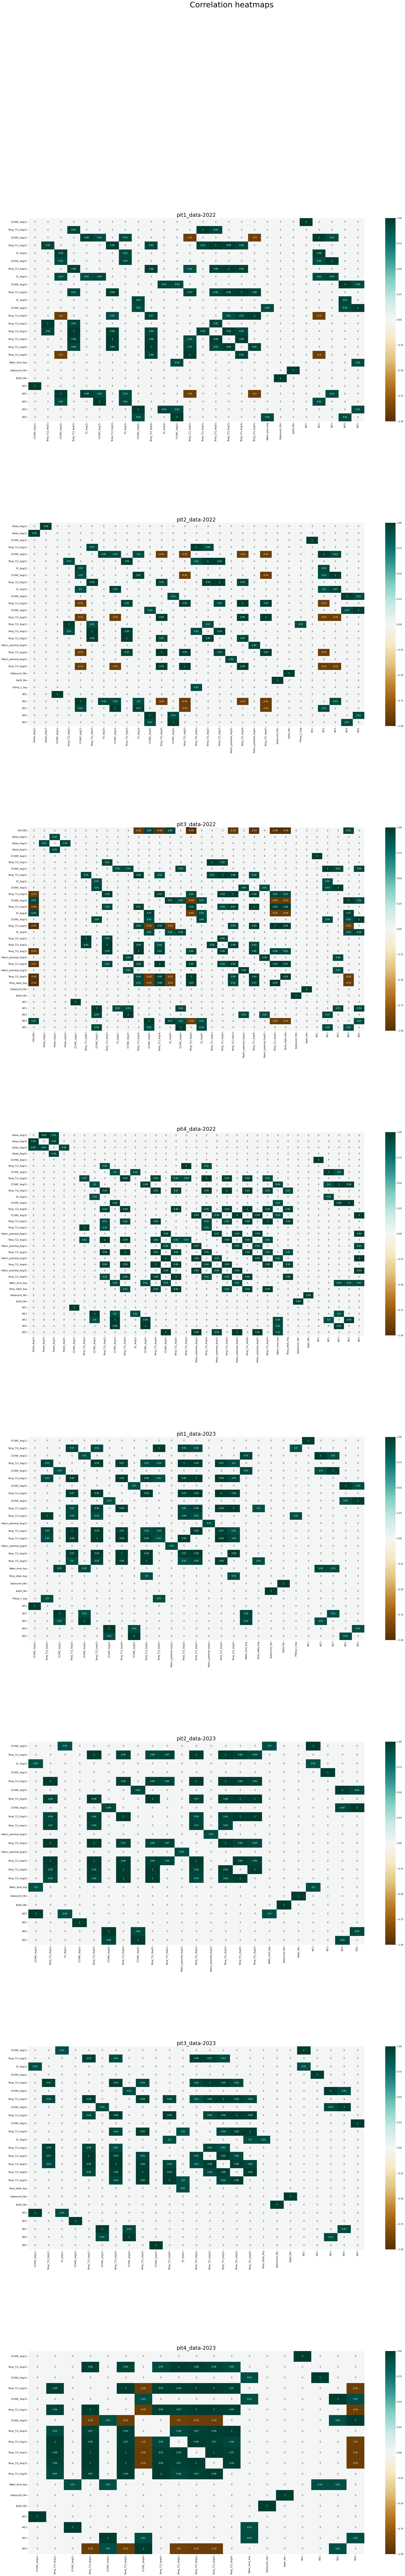

In [13]:
ncols = 1
nrows = len(raw_data.keys())

plt.figure(figsize=(35,nrows*25))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Correlation heatmaps", fontsize=36, y=0.95)

for n, (d_name, df) in enumerate(raw_data.items()):
    ax = plt.subplot(nrows, ncols, n + 1)

    corr_df = get_df_corr(df)
    corr_df = corr_df.apply(lambda x: get_corr_metrics(x, 0.9))

    # Set diagonal to 0
    np.fill_diagonal(corr_df.values, 0)
    # Remove columns with only 0 values
    corr_df = corr_df.loc[(corr_df > 0).any()]
    # Remove rows with only 0 values
    corr_df = corr_df.loc[:,(corr_df > 0).any()]

    sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

    ax.set_title(d_name, fontsize = 24)

### Get values according to findigs csv rows

In [11]:
# start = 11559 - 2 
# end = 11582 - 1
# pit = 'VII_PIT4_2022'
# clean_data[pit][clean_data[pit]['TIMESTAMP'].duplicated() == True]
# clean_data[pit]['TIMESTAMP'].iloc[start:end]

In [2]:
train = pd.read_csv('../../Data/Raw_training_data_full.csv',parse_dates=['TIMESTAMP']) #change path if needed

pit = 2

train = train.loc[train['pit_number']==pit]

/tmp/ipykernel_1902834/271617342.py:1: DtypeWarning: Columns (54,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('../../Data/Raw_training_data_full.csv',parse_dates=['TIMESTAMP']) #change path if needed


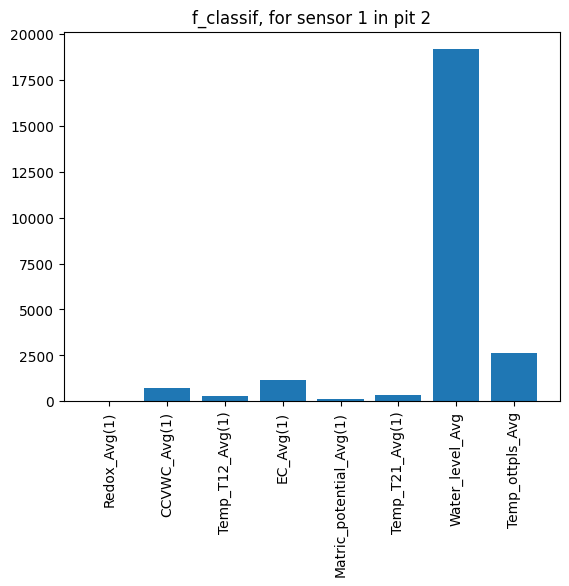

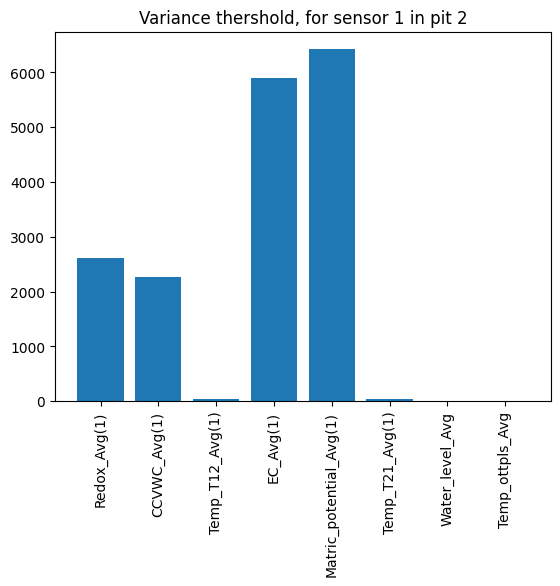

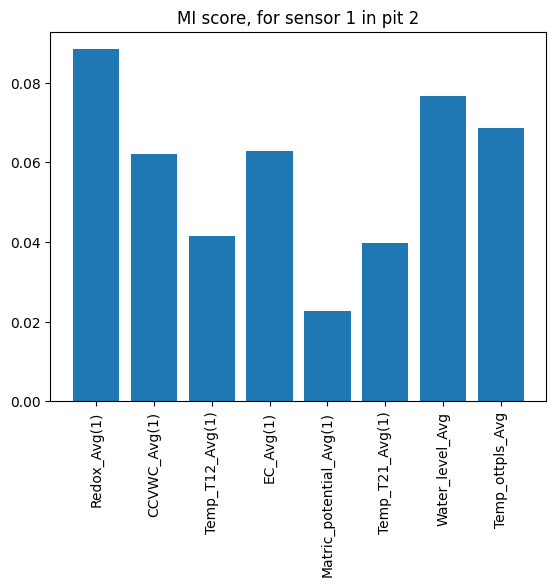

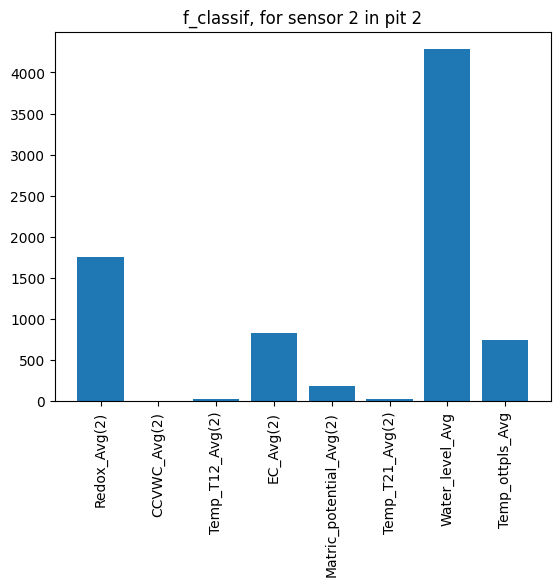

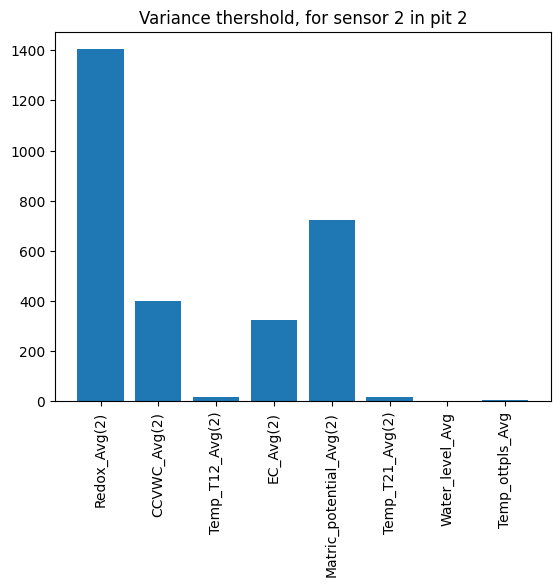

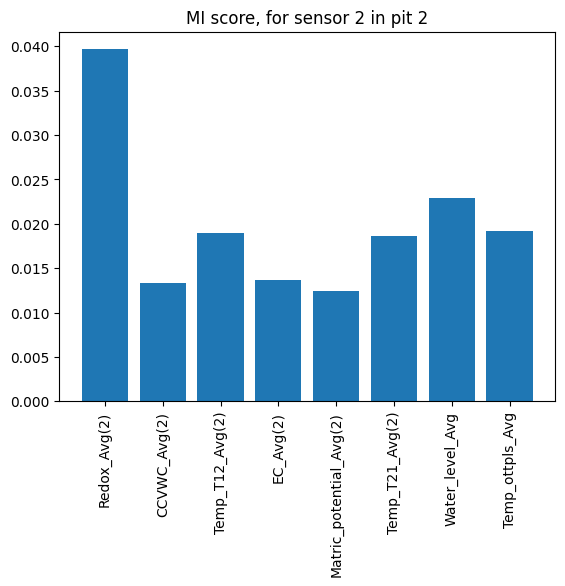

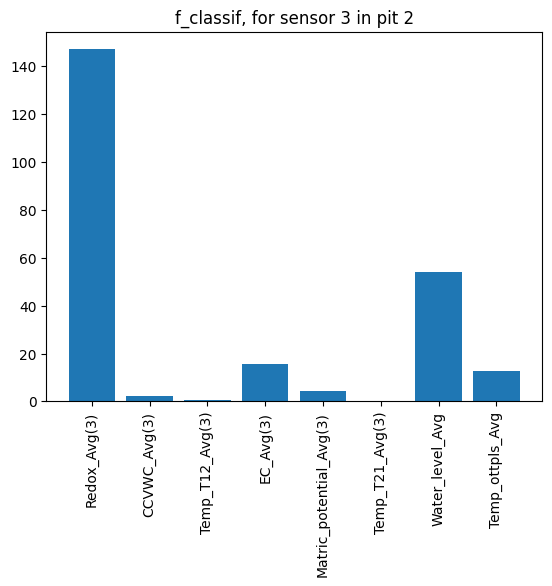

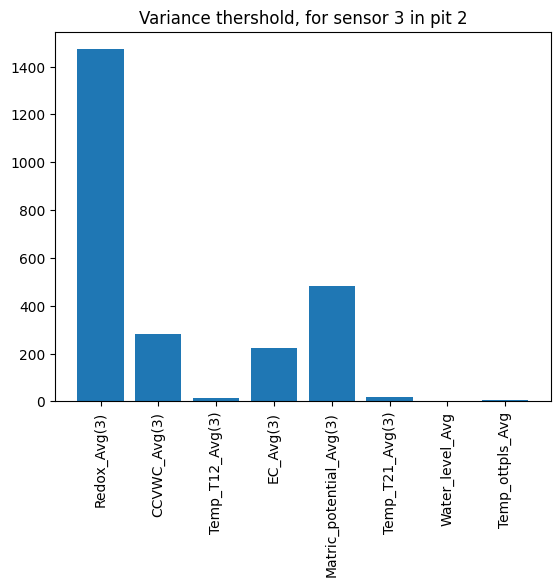

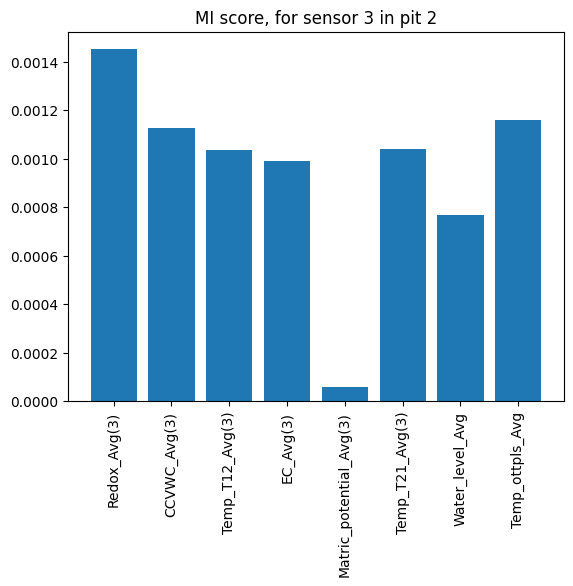

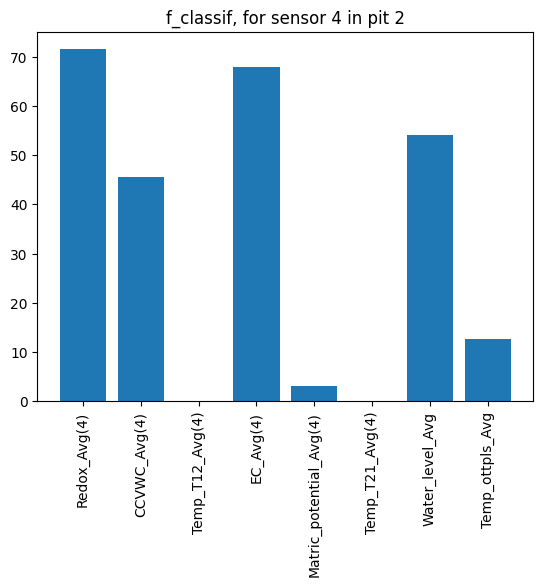

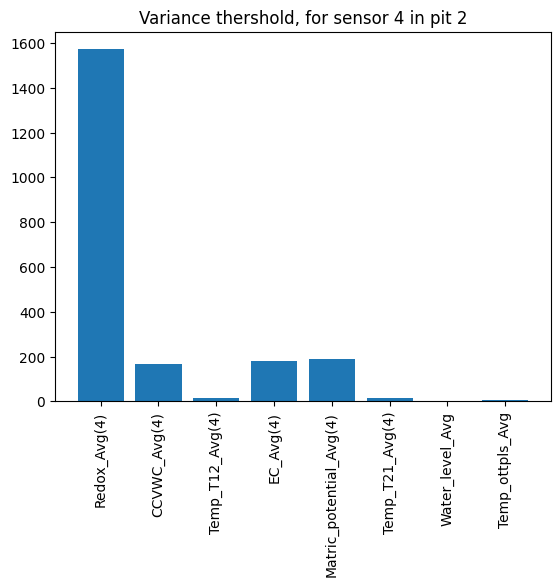

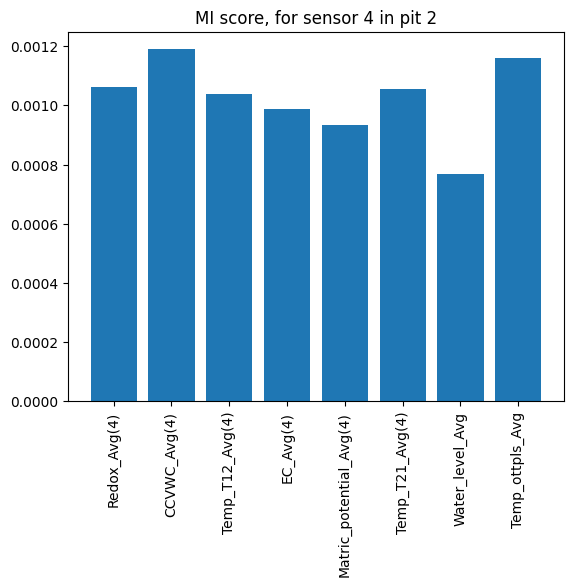

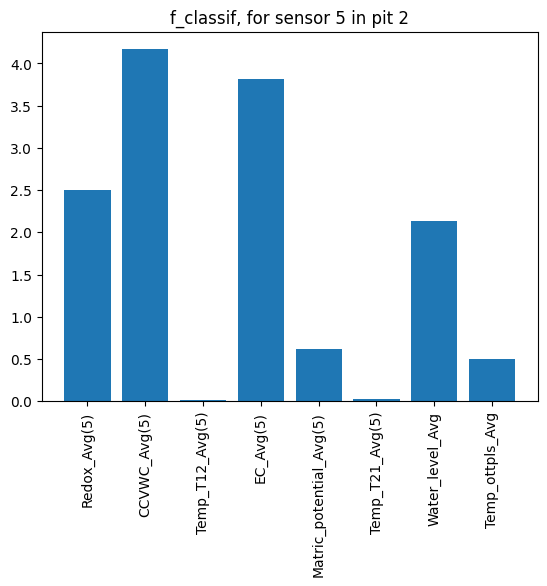

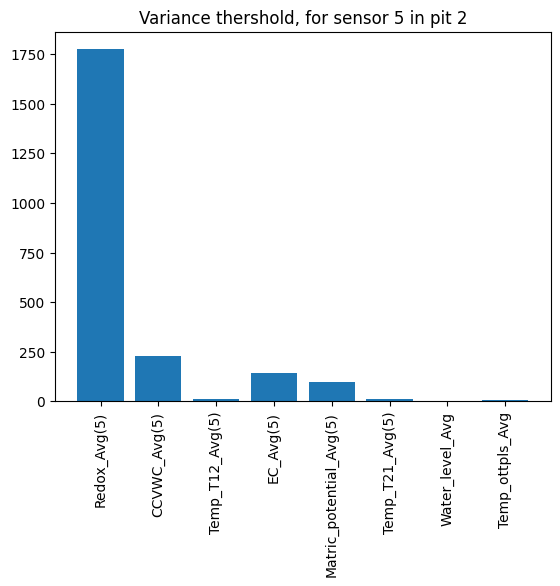

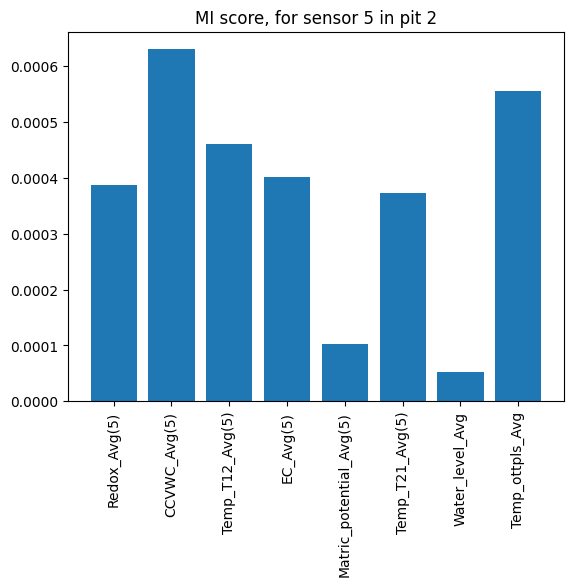

In [3]:

for i in range(1,6):
    columns = [f'Redox_Avg({i})', f'CCVWC_Avg({i})',f'Temp_T12_Avg({i})',f'EC_Avg({i})',f'Matric_potential_Avg({i})',f'Temp_T21_Avg({i})','Water_level_Avg','Temp_ottpls_Avg']

    x_data = train[columns]


    target = train[f'Redox_error_flag({i})'].astype('bool')


    f_value = f_classif(x_data,target)

    

    plt.bar(x=columns, height=f_value[0])
    plt.xticks(rotation='vertical')
    plt.title(f'f_classif, for sensor {i} in pit 2')
    plt.show()

    selector = VarianceThreshold()

    selector.fit_transform(x_data)

    plt.bar(x=columns, height=selector.variances_)
    plt.xticks(rotation='vertical')
    plt.title(f'Variance thershold, for sensor {i} in pit 2')
    plt.show()

    MI_score = mutual_info_classif(x_data,target, random_state=0)

    plt.bar(x=columns, height=MI_score)
    plt.xticks(rotation='vertical')
    plt.title(f'MI score, for sensor {i} in pit 2')
    plt.show()

/home/yjarkko/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/yjarkko/.local/lib/python3.8/site-packages/pandas/core/arrays/masked.py:64: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (
/home/yjarkko/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/yjarkko/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/

For pit 2 sensor 1
Best accuracy score: 0.98
Best subset (indices): (0, 3, 4, 6)
Best subset (corresponding names): ('Redox_Avg(1)', 'EC_Avg(1)', 'Matric_potential_Avg(1)', 'Temp_ottpls_Avg')


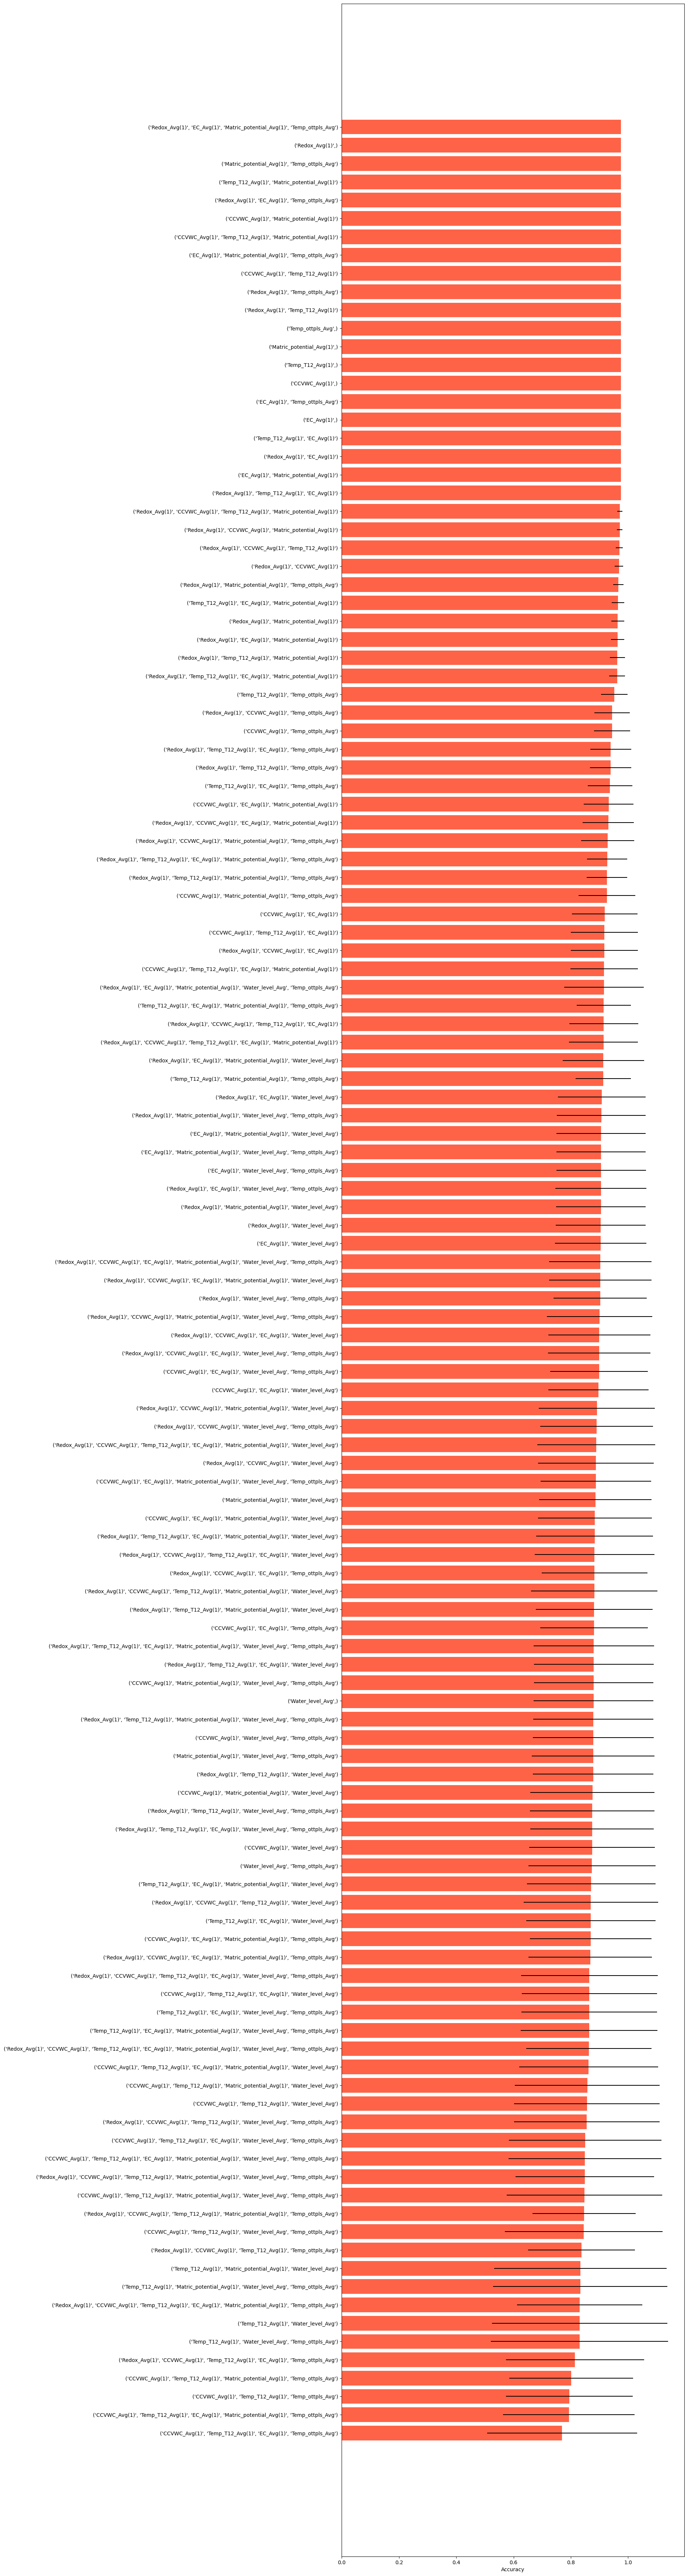

Features: 127/127

For pit 2 sensor 2
Best accuracy score: 0.99
Best subset (indices): (1,)
Best subset (corresponding names): ('CCVWC_Avg(2)',)


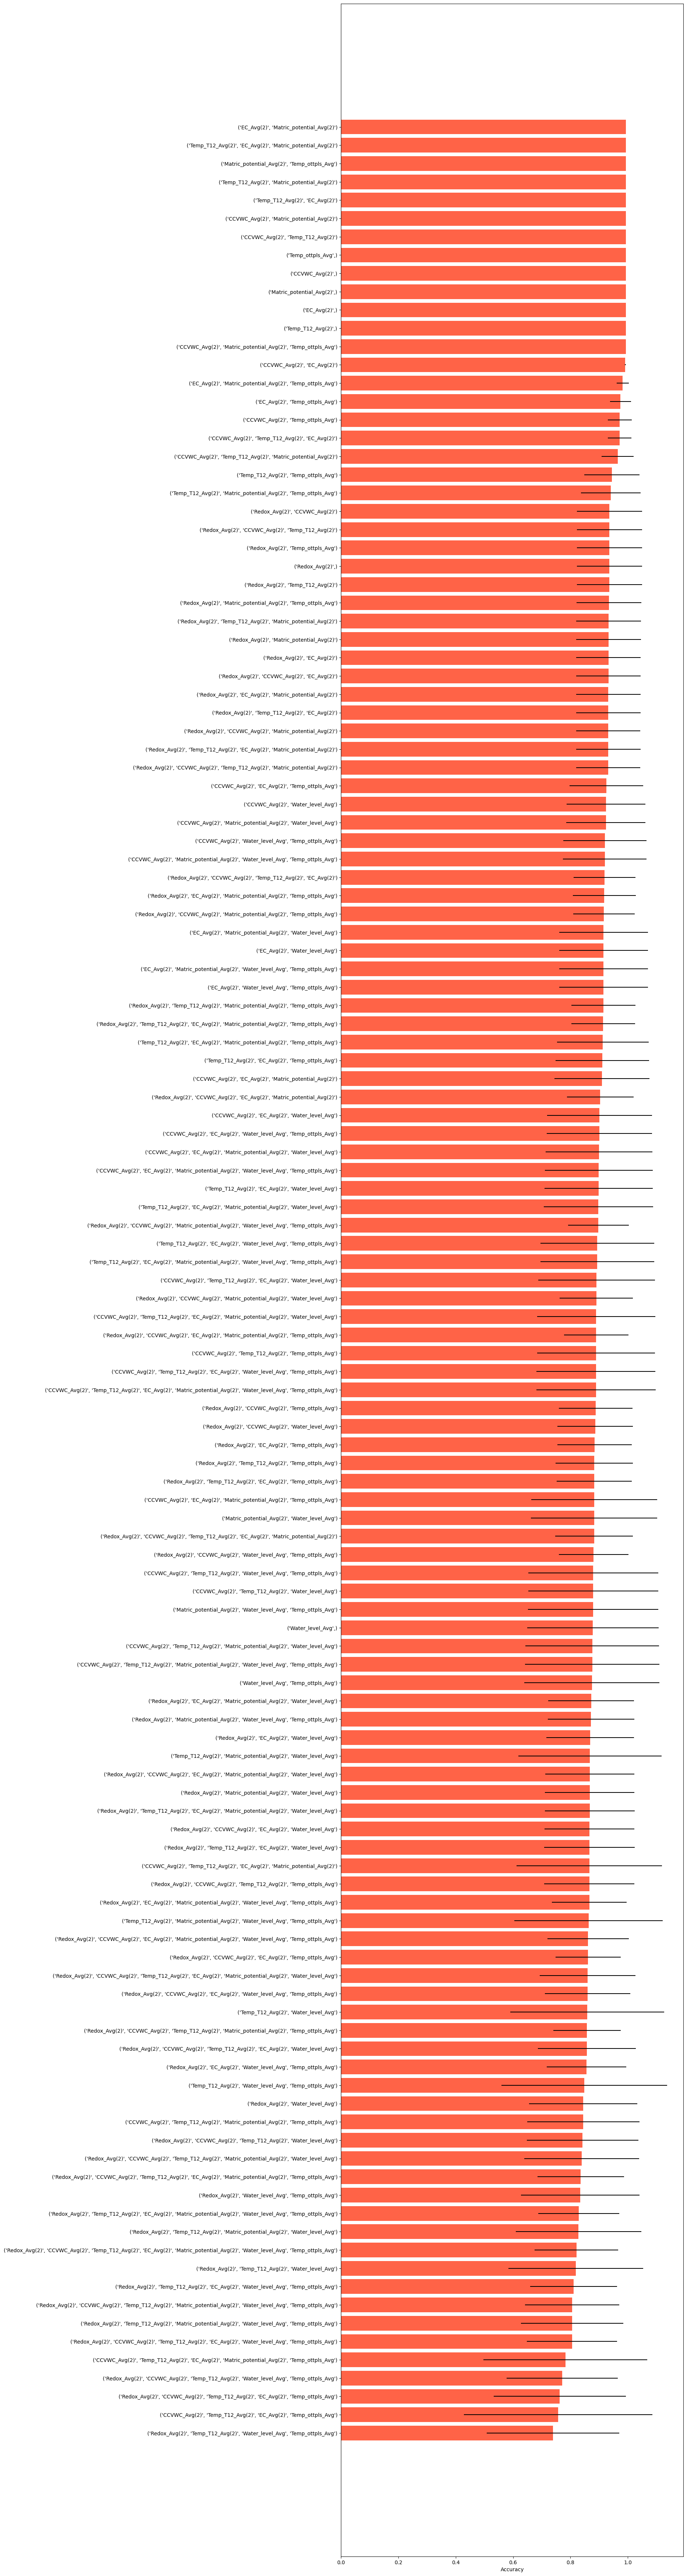

Features: 127/127

For pit 2 sensor 3
Best accuracy score: 1.00
Best subset (indices): (1,)
Best subset (corresponding names): ('CCVWC_Avg(3)',)


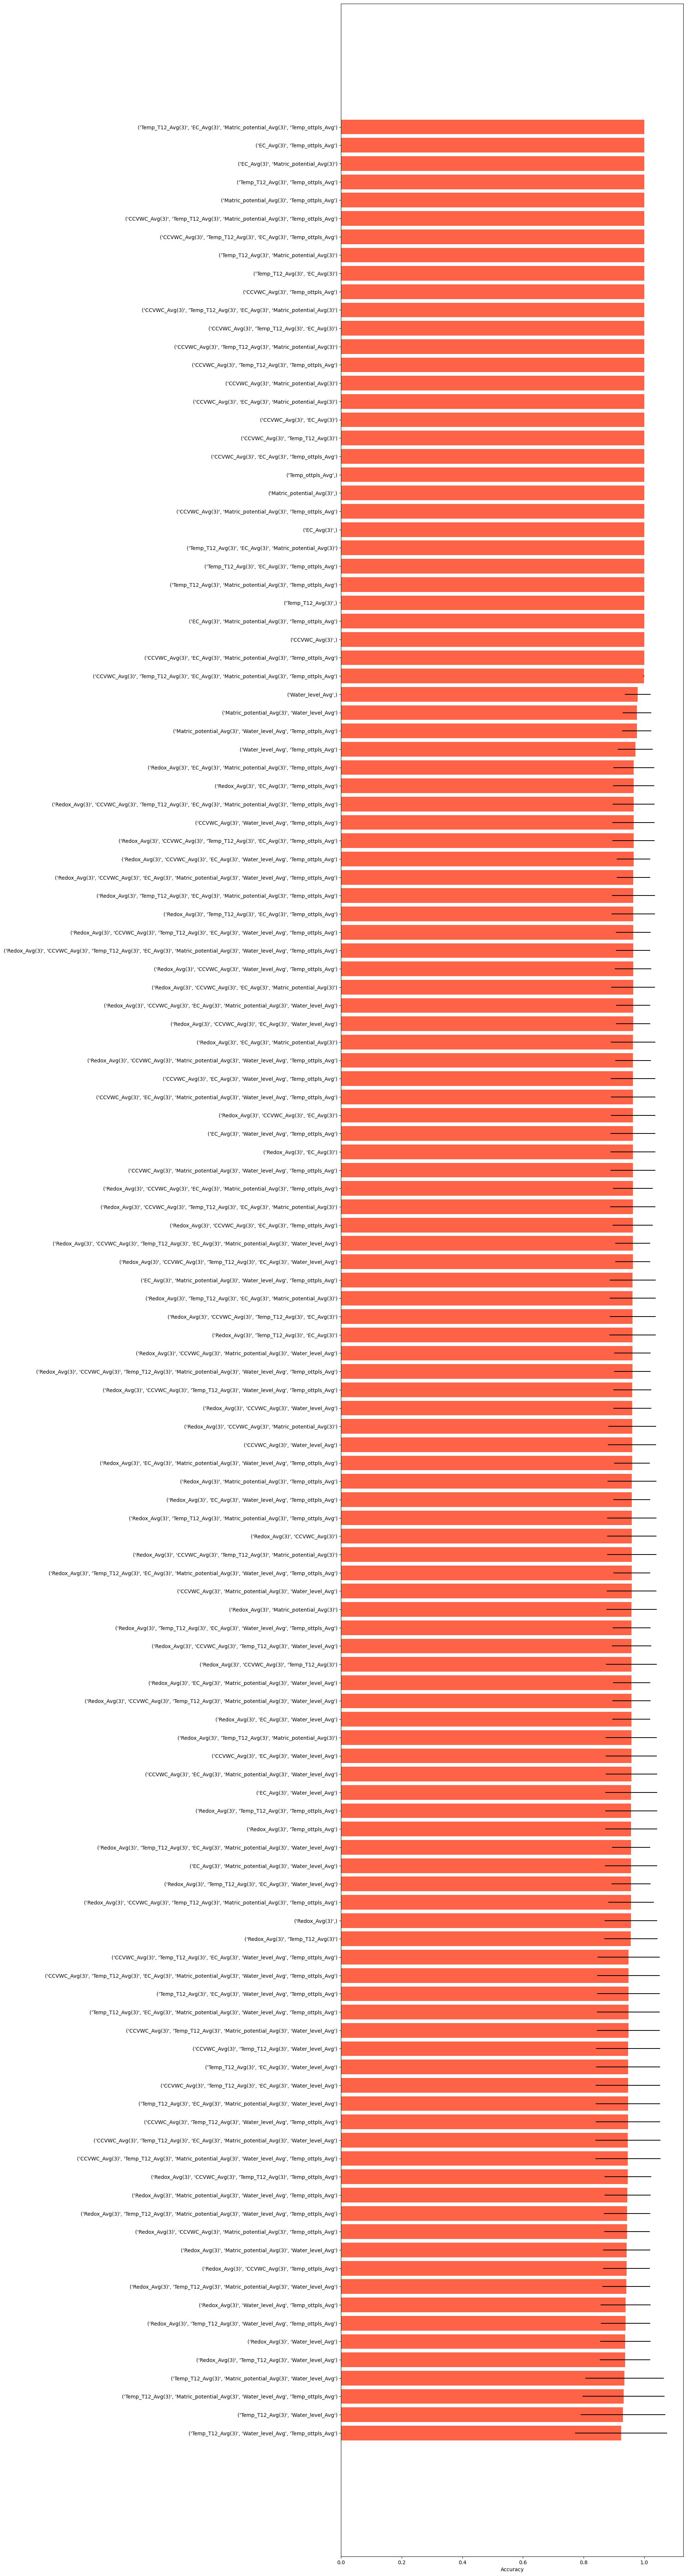

Features: 127/127

For pit 2 sensor 4
Best accuracy score: 1.00
Best subset (indices): (1,)
Best subset (corresponding names): ('CCVWC_Avg(4)',)


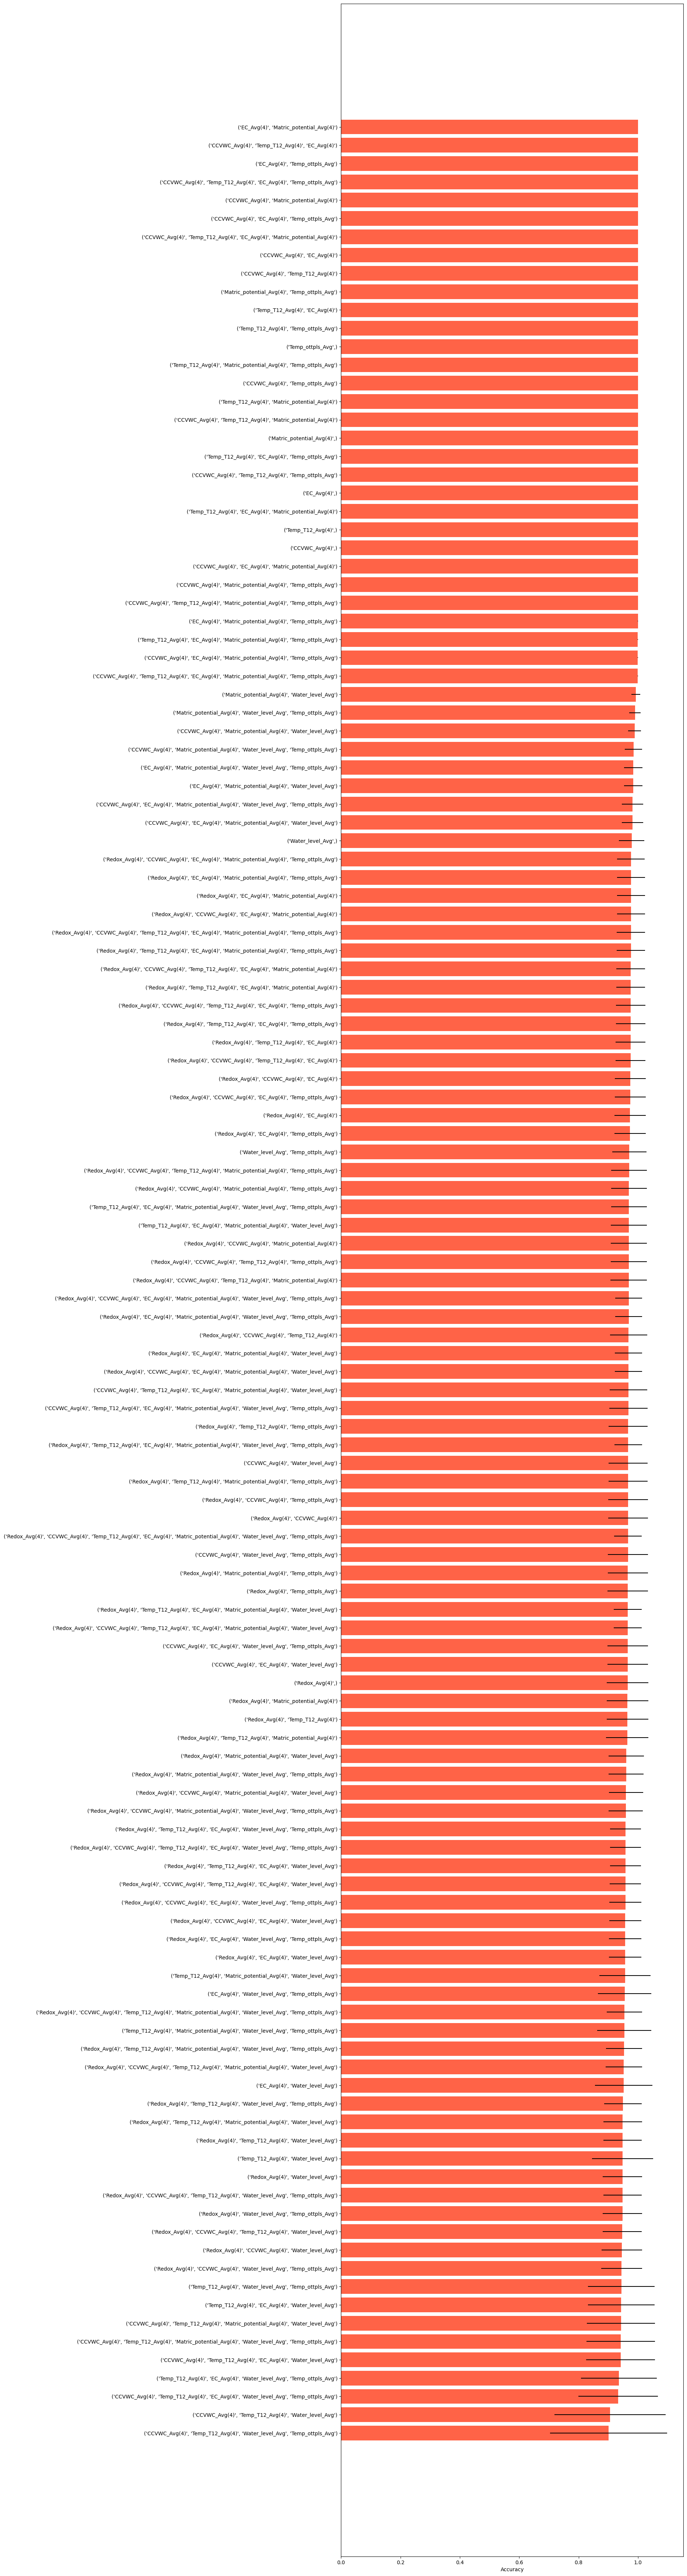

/home/yjarkko/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/yjarkko/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/yjarkko/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/yjarkko/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
---------------------------------

UnboundLocalError: local variable 'best_subset' referenced before assignment

In [4]:
for i in range(1,6):
    columns = [f'Redox_Avg({i})', f'CCVWC_Avg({i})',f'Temp_T12_Avg({i})',f'EC_Avg({i})',f'Matric_potential_Avg({i})','Water_level_Avg','Temp_ottpls_Avg']

    x_data = train[columns]


    target = train[f'Redox_error_flag({i})'].astype('bool')
    test = pd.unique(target)
    if len(test)<2:
        print(f'pit 1 sensor {i} has only False or True values')
        continue 


    scaler = StandardScaler()

    x_data = scaler.fit_transform(x_data)

    x_data= pd.DataFrame(x_data, columns=columns)



    lr = LogisticRegression(max_iter=1000, random_state=0) # Regressor can be changed here

# Create an EFS object
    efs = EFS(estimator=lr,        # Use logistic regression as the classifier/estimator
            min_features=1,      # The minimum number of features to consider is 1
            max_features=7,      # The maximum number of features to consider is 4
            scoring='accuracy',  # The metric to use to evaluate the classifier is accuracy 
            cv=5,
            n_jobs=3)                # The number of cross-validations to perform is 5

# Train EFS with our dataset
    efs = efs.fit(x_data, target)

# Print the results
    print(f'For pit 2 sensor {i}')
    print('Best accuracy score: %.2f' % efs.best_score_) # best_score_ shows the best score 
    print('Best subset (indices):', efs.best_idx_)       # best_idx_ shows the index of features that yield the best score 
    print('Best subset (corresponding names):', efs.best_feature_names_)

    efs_results = pd.DataFrame.from_dict(efs.get_metric_dict()).T
    efs_results.sort_values(by='avg_score', ascending=True, inplace=True)


    fig, ax = plt.subplots(figsize=(12,90))
    y_pos = np.arange(len(efs_results))
    ax.barh(y_pos, 
        efs_results['avg_score'],
        xerr=efs_results['std_dev'],
        color='tomato')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(efs_results['feature_names'])
    ax.set_xlabel('Accuracy')
    plt.show()